# Visualization and inspection
* Visualize importances, globally, locally.
* Trace influential variables to geographic locations by mapping importance
* Plot fields for important variables at moments in time
* Scatter influential variables against y
* Plot shap contributions to y = f(x)

In [1]:
import sys
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import shap
from scipy.signal import detrend
from pathlib import Path

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.utils import collapse_restore_multiindex, get_nhplus, get_nhmin, get_europe
from Weave.models import HybridExceedenceModel

from Weave.inspection import ImportanceData, MapInterface, data_for_shapplot, yplot, dotplot, barplot, mapplot, scatterplot, in_out_kept
#logging.basicConfig(level = logging.DEBUG)
shap.initjs()

In [2]:
basepath = Path('/nobackup_1/users/straaten/')
#basepath = Path('/scistor/ivm/jsn295/')
# Latest results:
quantile = 0.666 # options: 0.666 and 0.8
permimppath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
shappath = basepath / f'shap_stdback_train_q0{str(quantile)[2:]}'
#shappath = basepath / f'shap_pathdep_val_q0{str(quantile)[2:]}'
inputpath = basepath / 'clusters_cv_spearmanpar_varalpha_strict' # Latest dimreduced X and y data 
anompath = basepath / 'processed'

## comparing computation on_val with on_train
We suspect that especially for non-stationary variables this makes a difference. (Especially affecting folds 3 and 4 when it is climate change, if multi-decadal then all folds equally). With non-stionarity one expects that the model will perform worse. The factor was fitted in training, by being outside the range in validation it influences predictions unwanted.
* Potentially this increases its shap value in the validation data. The combined effect of its importance in training and non-stationarity. So should also have reasonable shap in train.
* Because it makes the model worse, permuting it will not degrade the model a lot further, in other words the variable becomes unimportant, even though it has affected everything. One would expect a great drop in singlepass importance from train to val.
* For both shap and permimp we expect that unimportant non-stationary variables are low in both validation and training fold. (Unless you get weird extrapolation effects from the important non-stationary variables)

What is the effect on our plotting capabilities:
* We can still plot global importance for the regions per fold (only then in its training period)
* for the local importance we suddenly have the datapoint in different folds (with differing clusters)

How could we remove a fold dimension?
* Clipping away cells that do not occur in at least X of the 5 folds
* Then averaging the importance values.
* Probably should be done in the map to fields.

In [13]:
shapvalpath = basepath / f'shap_stdback_val_q0{str(quantile)[2:]}'
shaptrainpath = basepath / f'shap_stdback_train_q0{str(quantile)[2:]}'
permvalpath = basepath / f'permimp_val_q0{str(quantile)[2:]}'
permtrainpath = basepath / f'permimp_train_q0{str(quantile)[2:]}'
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
respagg = 31
separation = -15
shapval = ImportanceData(shapvalpath, respagg, separation, quantile, model)
shapval.load_data(inputpath=inputpath, X_too = True)
shaptrain = ImportanceData(shaptrainpath, respagg, separation, quantile, model)
shaptrain.load_data(inputpath=inputpath, X_too = True)
permval = ImportanceData(permvalpath, respagg, separation, quantile, model)
permval.load_data(inputpath=inputpath, X_too = True)
permtrain = ImportanceData(permtrainpath, respagg, separation, quantile, model)
permtrain.load_data(inputpath=inputpath, X_too = True)

In [14]:
permtrain.scale_within(fill_na = True)
permval.scale_within(fill_na = True)
shapval.global_shap()
shaptrain.global_shap()

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

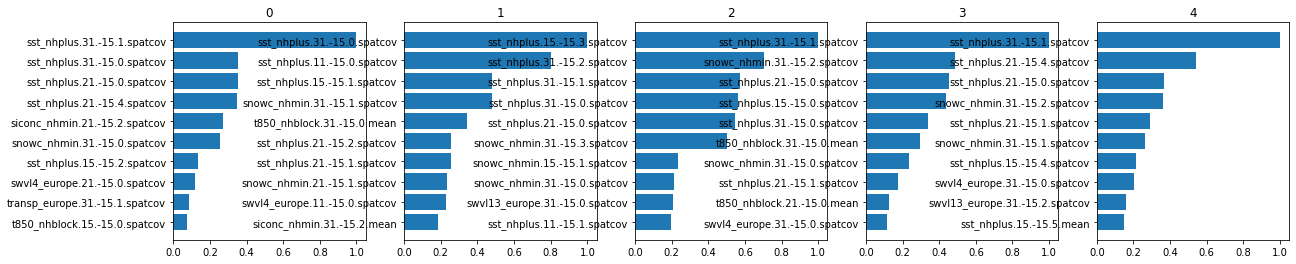

In [17]:
barplot(permtrain.df.loc[:,('singlepass','score')].unstack('fold'),ignore_in_names=['respagg', 'lag'])

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

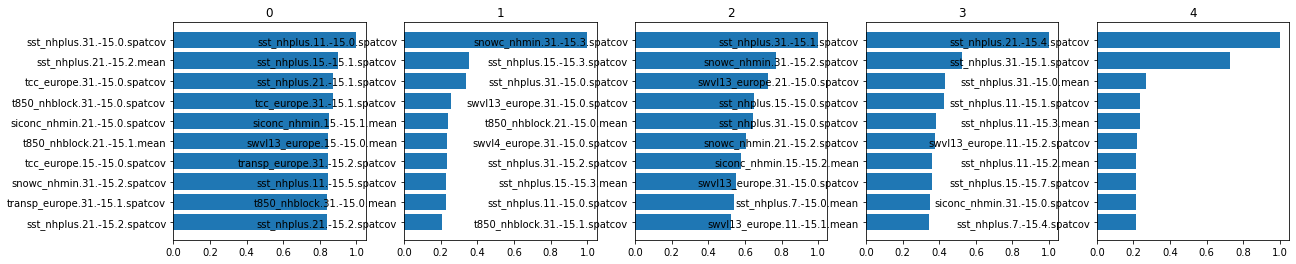

In [18]:
barplot(permval.df.loc[:,('singlepass','score')].unstack('fold'),ignore_in_names=['respagg', 'lag'])

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

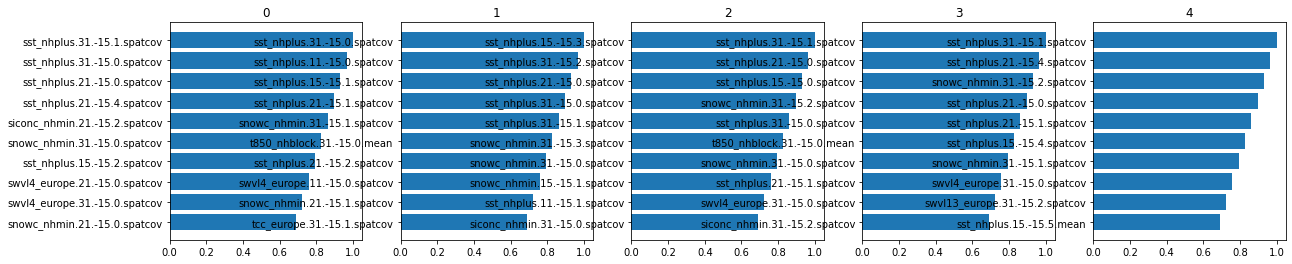

In [6]:
barplot(permtrain.df.loc[:,('multipass','rank')].unstack('fold'),ignore_in_names=['respagg', 'lag'])

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

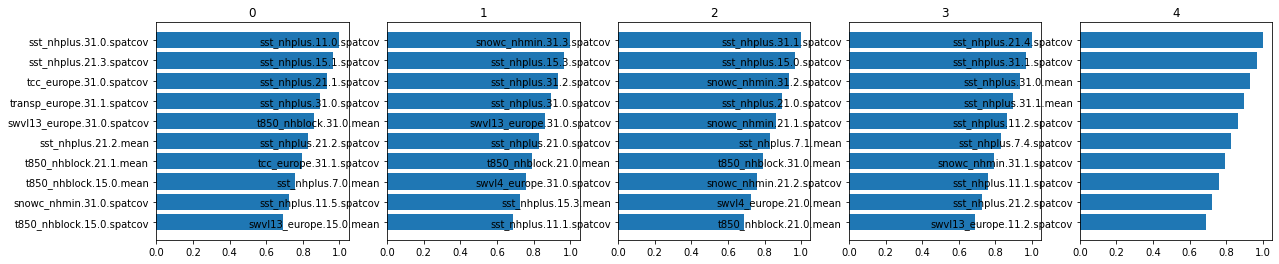

In [11]:
barplot(permval.df.loc[:,('multipass','rank')].unstack('fold'),ignore_in_names=['respagg', 'lag','separation'])

In [31]:
base = permtrain.df.loc[:,('multipass','rank')].unstack('fold')
other = permval.df.loc[:,('multipass','rank')].unstack('fold')
new, out, kept = in_out_kept(base, other, ignore_in_names=['respagg','lag','separation'])

In [32]:
new

fold,0,1,2,3,4
other_imp,,,,,
1,sst_nhplus.21.3.spatcov,NaN,NaN,NaN,NaN
2,tcc_europe.31.0.spatcov,NaN,NaN,NaN,sst_nhplus.31.0.mean
3,transp_europe.31.1.spatcov,NaN,NaN,NaN,sst_nhplus.31.1.mean
4,swvl13_europe.31.0.spatcov,NaN,swvl13_europe.31.0.spatcov,snowc_nhmin.21.1.spatcov,sst_nhplus.11.2.spatcov
5,sst_nhplus.21.2.mean,NaN,NaN,sst_nhplus.7.1.mean,sst_nhplus.7.4.spatcov
6,t850_nhblock.21.1.mean,tcc_europe.31.1.spatcov,t850_nhblock.21.0.mean,NaN,NaN
7,t850_nhblock.15.0.mean,sst_nhplus.7.0.mean,swvl4_europe.31.0.spatcov,snowc_nhmin.21.2.spatcov,sst_nhplus.11.1.spatcov
8,NaN,sst_nhplus.11.5.spatcov,sst_nhplus.15.3.mean,swvl4_europe.21.0.mean,sst_nhplus.21.2.spatcov


In [33]:
base = permtrain.df.loc[:,('singlepass','score')].unstack('fold')
other = permval.df.loc[:,('singlepass','score')].unstack('fold')
new, out, kept = in_out_kept(base, other, ignore_in_names=['respagg','lag','separation'])

In [34]:
new

fold,0,1,2,3,4
other_imp,,,,,
1,sst_nhplus.21.2.mean,NaN,NaN,NaN,NaN
2,tcc_europe.31.0.spatcov,NaN,NaN,swvl13_europe.21.0.spatcov,sst_nhplus.31.0.mean
3,t850_nhblock.31.0.spatcov,tcc_europe.31.1.spatcov,NaN,NaN,sst_nhplus.11.1.spatcov
4,siconc_nhmin.21.0.spatcov,siconc_nhmin.15.1.mean,t850_nhblock.21.0.mean,NaN,sst_nhplus.11.3.mean
5,t850_nhblock.21.1.mean,swvl13_europe.15.0.mean,swvl4_europe.31.0.spatcov,snowc_nhmin.21.2.spatcov,swvl13_europe.11.2.spatcov
6,tcc_europe.15.0.spatcov,transp_europe.31.2.spatcov,NaN,siconc_nhmin.15.2.mean,sst_nhplus.11.2.mean
7,snowc_nhmin.31.2.spatcov,sst_nhplus.11.5.spatcov,sst_nhplus.15.3.mean,swvl13_europe.31.0.spatcov,sst_nhplus.15.7.spatcov
8,NaN,NaN,sst_nhplus.11.0.spatcov,sst_nhplus.7.0.mean,siconc_nhmin.31.0.spatcov


Within Training the multipass and singlepass are remarkably consistent. Weird since multipass was designed to accomodate for information redundancy when two predictors are colinear (making both unimportant). This should mean that colinearity is less of an issue. Or that the fitting has been so random that the information was divided anyway over the models.

When going from training to validation you see for singlepass a lot of difference. Also the raw BS values in validation become less differentiated from each other (this is less visible after the scaling), basically because the model always has trouble. 
Luckily for instance to top predictor in training is also in the validation selection. (except for fold 1 and 0). Around 2-5 predictors are kept. This disappearing important ones are thus non-stationary I guess. And it should according to the expectation not drop out at shap-val (and it multipass it should also disappear.)

When going from training to validation with multipass, about 2-6 predictors are kept. Meaning slightly less new enter than in singlepass. These kept variables appear similar to singlepass. Looking at the new ones entering (in training unimportant) there is less corresponding with the ones entering in singlepass. 

Indeed the shap from train to val is also very consistent. Some values are slightly enlarged or lessened and order can change a bit. But hardly any new variables enter.

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

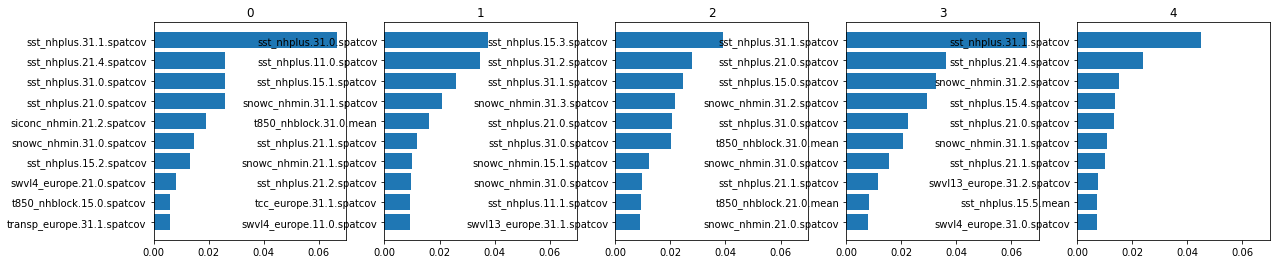

In [22]:
barplot(shaptrain.df.loc[:,('avgabsshap')].unstack('fold'),ignore_in_names=['respagg', 'lag','separation'])

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

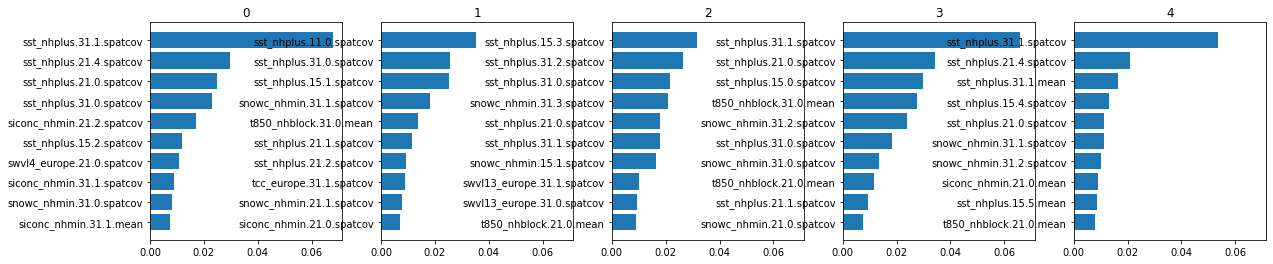

In [23]:
barplot(shapval.df.loc[:,('avgabsshap')].unstack('fold'),ignore_in_names=['respagg', 'lag','separation'])

Now lets just investigate the difference between train shap and train permimp (multi and single are comparable for training). From the dotplots in validation we remember that permimp painted more diverse pictures. Actually the variable sets are very similar.

In [45]:
base = shaptrain.df.loc[:,('avgabsshap')].unstack('fold')
other = permtrain.df.loc[:,('multipass','rank')].unstack('fold')
new, out, kept = in_out_kept(base, other, ignore_in_names=['respagg','lag','separation'])

In [46]:
kept # from shap to multipass

fold,0,1,2,3,4
base_imp,,,,,
0,sst_nhplus.31.1.spatcov,sst_nhplus.31.0.spatcov,sst_nhplus.15.3.spatcov,sst_nhplus.31.1.spatcov,sst_nhplus.31.1.spatcov
1,sst_nhplus.21.4.spatcov,sst_nhplus.11.0.spatcov,sst_nhplus.31.2.spatcov,sst_nhplus.21.0.spatcov,sst_nhplus.21.4.spatcov
2,sst_nhplus.31.0.spatcov,sst_nhplus.15.1.spatcov,sst_nhplus.31.1.spatcov,sst_nhplus.15.0.spatcov,snowc_nhmin.31.2.spatcov
3,sst_nhplus.21.0.spatcov,snowc_nhmin.31.1.spatcov,snowc_nhmin.31.3.spatcov,snowc_nhmin.31.2.spatcov,sst_nhplus.15.4.spatcov
4,siconc_nhmin.21.2.spatcov,t850_nhblock.31.0.mean,sst_nhplus.21.0.spatcov,sst_nhplus.31.0.spatcov,sst_nhplus.21.0.spatcov
5,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov,sst_nhplus.31.0.spatcov,t850_nhblock.31.0.mean,snowc_nhmin.31.1.spatcov
6,sst_nhplus.15.2.spatcov,snowc_nhmin.21.1.spatcov,snowc_nhmin.15.1.spatcov,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov
7,swvl4_europe.21.0.spatcov,sst_nhplus.21.2.spatcov,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov,swvl13_europe.31.2.spatcov
8,NaN,NaN,sst_nhplus.11.1.spatcov,NaN,NaN


In [44]:
kept # from shap to singlepass

fold,0,1,2,3,4
base_imp,,,,,
0,sst_nhplus.31.1.spatcov,sst_nhplus.31.0.spatcov,sst_nhplus.15.3.spatcov,sst_nhplus.31.1.spatcov,sst_nhplus.31.1.spatcov
1,sst_nhplus.21.4.spatcov,sst_nhplus.11.0.spatcov,sst_nhplus.31.2.spatcov,sst_nhplus.21.0.spatcov,sst_nhplus.21.4.spatcov
2,sst_nhplus.31.0.spatcov,sst_nhplus.15.1.spatcov,sst_nhplus.31.1.spatcov,sst_nhplus.15.0.spatcov,snowc_nhmin.31.2.spatcov
3,sst_nhplus.21.0.spatcov,snowc_nhmin.31.1.spatcov,snowc_nhmin.31.3.spatcov,snowc_nhmin.31.2.spatcov,sst_nhplus.15.4.spatcov
4,siconc_nhmin.21.2.spatcov,t850_nhblock.31.0.mean,sst_nhplus.21.0.spatcov,sst_nhplus.31.0.spatcov,sst_nhplus.21.0.spatcov
5,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov,sst_nhplus.31.0.spatcov,t850_nhblock.31.0.mean,snowc_nhmin.31.1.spatcov
6,sst_nhplus.15.2.spatcov,snowc_nhmin.21.1.spatcov,snowc_nhmin.15.1.spatcov,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov
7,swvl4_europe.21.0.spatcov,sst_nhplus.21.2.spatcov,snowc_nhmin.31.0.spatcov,sst_nhplus.21.1.spatcov,swvl13_europe.31.2.spatcov
8,NaN,NaN,NaN,t850_nhblock.21.0.mean,NaN


In [15]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=shaptrain)

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<GeoAxesSubplot:title={'center':'fold = 0, separation = -15, timeagg = 31'}, ylabel="(0, 't850_nhblock', 31, -15)">,
         <GeoAxesSubplot:title={'center':'fold = 1, separation = -15, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'fold = 2, separation = -15, timeagg = 31'}>],
        [<GeoAxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <GeoAxesSubplot:title={'center':'fold = 4, separation = -15, timeagg = 31'}>,
         <GeoAxesSubplot:>]], dtype=object))

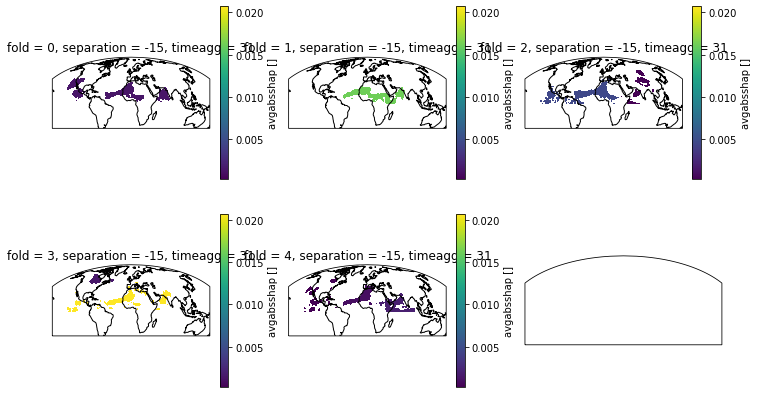

In [37]:
metricsep = shaptrain.df.index.get_loc_level('mean','metric')[0]
frame = shaptrain.df.loc[metricsep,:].loc[(slice(None),slice(None),'t850_nhblock',31),'avgabsshap']
mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True)
#mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True, projection=ccrs.Orthographic(0,90), region=get_nhmin())

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<GeoAxesSubplot:title={'center':'fold = 0, separation = -15, timeagg = 31'}, ylabel="(0, 't850_nhblock', 31, -15)">,
         <GeoAxesSubplot:title={'center':'fold = 1, separation = -15, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'fold = 2, separation = -15, timeagg = 31'}>],
        [<GeoAxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <GeoAxesSubplot:title={'center':'fold = 4, separation = -15, timeagg = 31'}>,
         <GeoAxesSubplot:>]], dtype=object))

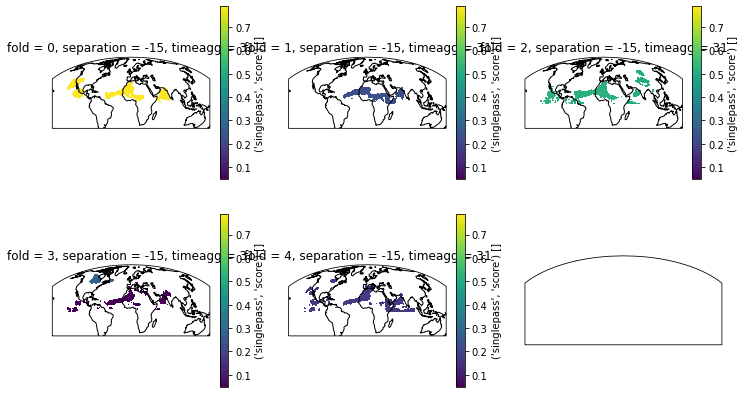

In [38]:
metricsep = permval.df.index.get_loc_level('mean','metric')[0]
frame = permval.df.loc[metricsep,:].loc[(slice(None),slice(None),'t850_nhblock',31),('singlepass','score')]
mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True)
#mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True, projection=ccrs.Orthographic(0,90), region=get_nhmin())

## Amount of input clusters
Independent of the response aggregation. Just dependent on the moment in time before the separation starts.

In [9]:
Xin = pd.read_parquet(inputpath / 'precursor.multiagg.parquet') # All are double because both spatcov and mean was extracted
Xin = Xin.loc[:, Xin.columns.get_loc_level('spatcov','metric')[0]].iloc[-1,:] # Only one timeslice needed.

In [22]:
groups = list(Xin.index.names)
groups.remove('clustid')
counts = Xin.groupby(groups).count()
# neccessary for the new cv-approach. To average over folds
groups.remove('fold')
counts = counts.groupby(groups).mean()
counts.index = pd.MultiIndex.from_frame(counts.index.to_frame().assign(respagg = 7)) # To make sure that a unique respagg is present such that non-unique separation becomes the x-var 
counts.name = 'mean_number_of_clusters_over_folds'

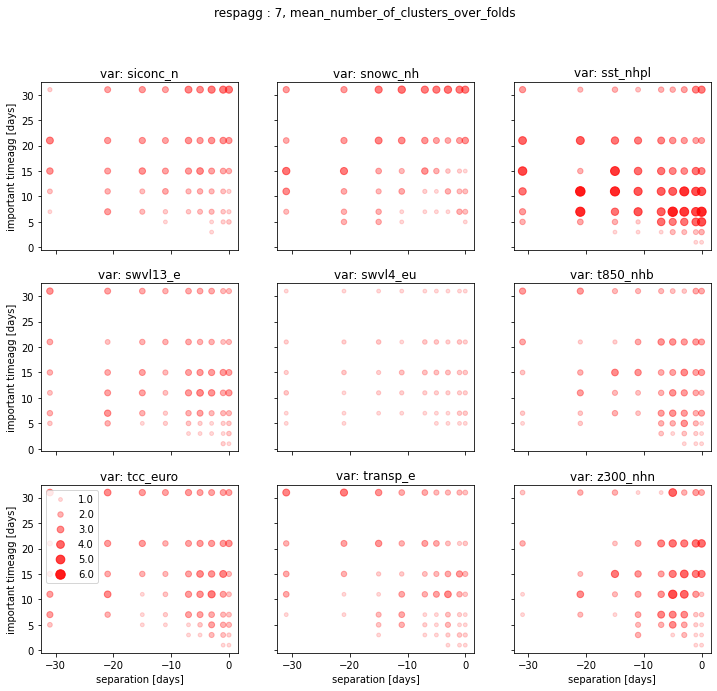

In [23]:
fig, axes = dotplot(counts, alphascaler = 0.15, nlegend_items=6, sizescaler=15)

## Importance of input

In [3]:
respagg_of_interest = [31] # [0,1,3,5,7,11,15,21,31]
separation_of_interest = -15 # [0,-1,-3,-5,-7,-11,-15,-21,-31]
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)

Shap specific

In [9]:
shaps = ImportanceData(shappath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
shaps.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaps.global_shap() # Reduces the column (time) axis.
shaps.reduce_over('metric', how = 'max')
shaps.reduce_over('clustid', how = 'mean') # Now max and or sum are doable (we have made absolute the large negative probabilistic influences)
shaps.reduce_over('fold', how = 'mean') # Reduce over the folds.

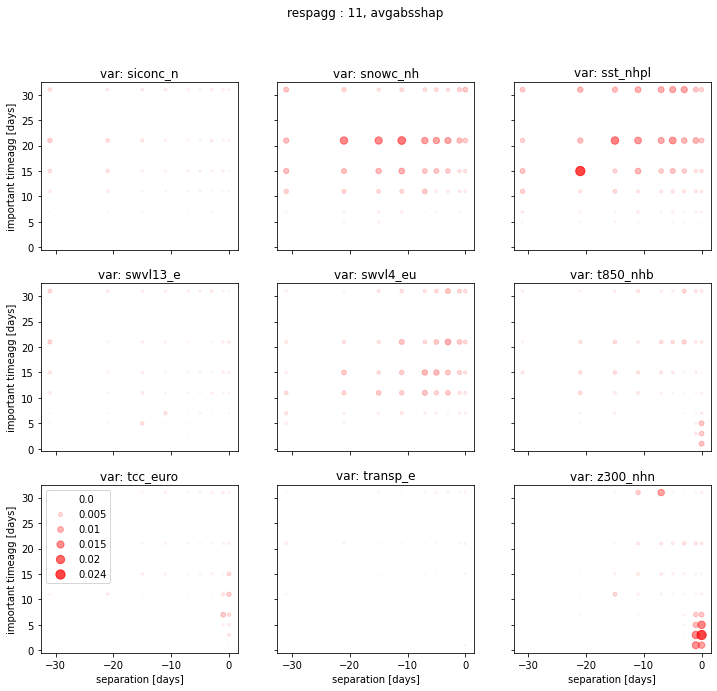

In [10]:
fig, axes = dotplot(shaps.df.iloc[:,0], alphascaler = 30, sizescaler=3500, nlegend_items=6)

In [23]:
shaps = ImportanceData(shappath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
shaps.load_data(inputpath=inputpath, X_too = True, y_too = True)
shaps.global_shap() # Reduces the column (time) axis.

ValueError: All objects passed were None

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'avgabsshap.0'}>,
         <AxesSubplot:title={'center':'avgabsshap.1'}>,
         <AxesSubplot:title={'center':'avgabsshap.2'}>,
         <AxesSubplot:title={'center':'avgabsshap.3'}>,
         <AxesSubplot:title={'center':'avgabsshap.4'}>]], dtype=object))

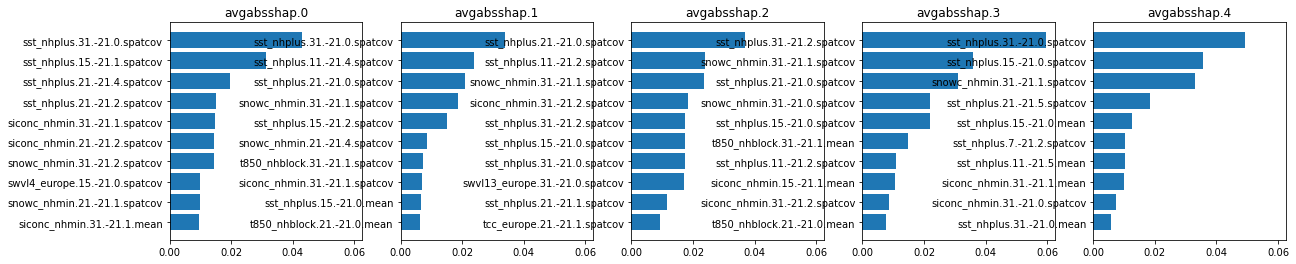

In [13]:
indexersep = shaps.df.index.get_loc_level(-21,'separation')[0]
barplot(shaps.df.loc[indexersep,:].unstack('fold'),ignore_in_names=['respagg', 'lag'])

In [6]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=shaps)

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<GeoAxesSubplot:title={'center':'separation = -21, fold = 0, timeagg = 31'}, ylabel="(0, 'siconc_nhmin', 31, -21)">,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 1, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 2, timeagg = 31'}>],
        [<GeoAxesSubplot:title={'center':'separation = -21, fold = 3, timeagg = 31'}, ylabel="(3, 'siconc_nhmin', 31, -21)">,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 4, timeagg = 31'}>,
         <GeoAxesSubplot:>]], dtype=object))

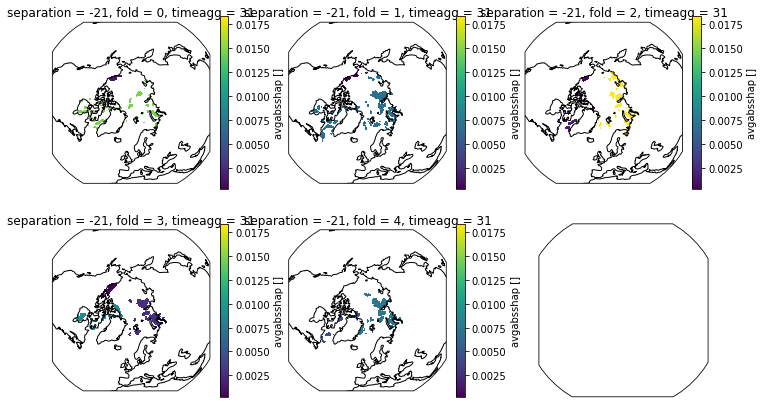

In [16]:
metricsep = shaps.df.index.get_loc_level('spatcov','metric')[0]
frame = shaps.df.loc[np.logical_and(indexersep,metricsep),:].loc[(slice(None),slice(None),'siconc_nhmin',31),'avgabsshap']
#mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True)
mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True, projection=ccrs.Orthographic(0,90), region=get_nhmin())

Shaps basically show more divergence in importance between the separations and between variables. There is no normalization per prediction situations. It is actual probabilistic impact (not a rank of it) and impact will be larger for the most confident prediction situations. 

At respagg 31 there is some role for swvl and snow cover. But not that much over all data. With max per fold the effect changes a bit. Transpiration, tcc, t850, z300 lack in impact.

permutation importance specific

In [4]:
permimps = ImportanceData(permimppath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
permimps.load_data(inputpath = inputpath, X_too = True, y_too = True)
permimps.scale_within(fill_na = True) # This scales within ['respagg','separation','fold'], so gets one model fit onto scale [0,1]
permimps.reduce_over('clustid', how = 'max') # Max does not equal sum here. Though it is similar in character (there are no negative importances)
permimps.reduce_over('metric', how = 'max')
#perm.df = perm.df.iloc[perm.df.index.get_loc_level('spatcov',level = 'metric')[0],:] # Selecting only one metric
permimps.reduce_over('fold', how = 'mean') # Mean equals sum here because the amount of folds is equal.

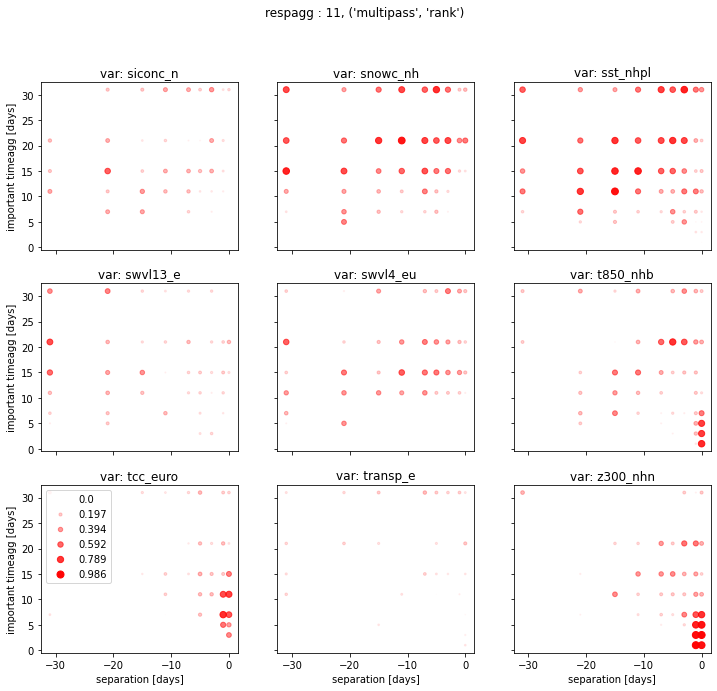

In [5]:
fig, axes = dotplot(permimps.df.iloc[:,2], alphascaler = 1, nlegend_items=6)

In [17]:
permimps = ImportanceData(permimppath, respagg=respagg_of_interest, separation= separation_of_interest, quantile = quantile, model=model)
permimps.load_data(inputpath = inputpath, X_too = True, y_too = True)
permimps.scale_within(fill_na = True)

(<Figure size 1440x288 with 5 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>]], dtype=object))

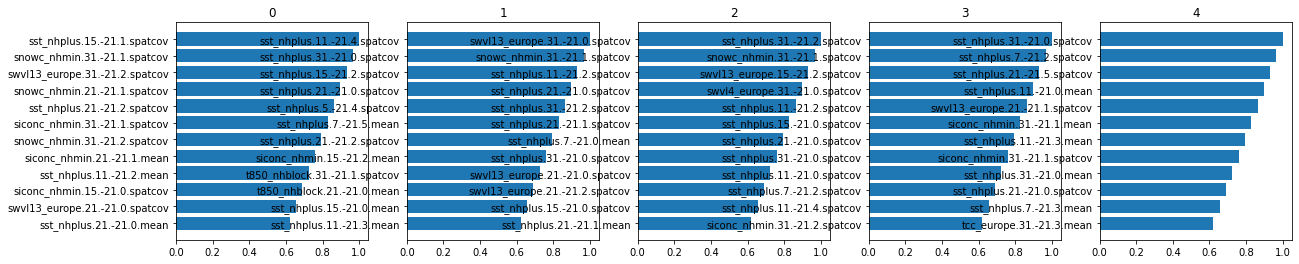

In [18]:
indexersep = permimps.df.index.get_loc_level(-21,'separation')[0]
barplot(permimps.df.loc[indexersep,('multipass','rank')].unstack('fold'),ignore_in_names=['respagg', 'lag'],n_most_important = 12)

In [62]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=permimps)

Rowkeys are thinned, so you could be losing some information here if not also present in the xarray name or attributes


(<Figure size 864x504 with 11 Axes>,
 array([[<GeoAxesSubplot:title={'center':'separation = -21, fold = 0, timeagg = 31'}, ylabel="(0, 'siconc_nhmin', 31, -21)">,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 1, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 2, timeagg = 31'}>],
        [<GeoAxesSubplot:title={'center':'separation = -21, fold = 3, timeagg = 31'}, ylabel="(3, 'siconc_nhmin', 31, -21)">,
         <GeoAxesSubplot:title={'center':'separation = -21, fold = 4, timeagg = 31'}>,
         <GeoAxesSubplot:>]], dtype=object))

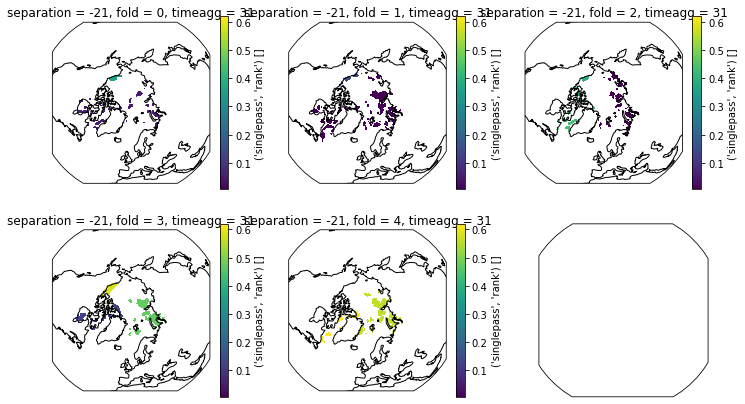

In [21]:
metricsep = permimps.df.index.get_loc_level('spatcov','metric')[0]
frame = permimps.df.loc[np.logical_and(indexersep,metricsep),:].loc[(slice(None),slice(None),'siconc_nhmin',31),('singlepass','rank')]
#mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True) #region = get_europe()
mapplot(mapint.map_to_fields(frame), wrap_per_row=3,match_scales=True, projection=ccrs.Orthographic(0,90), region=get_nhmin())

### Shap again. Interaction?

In [12]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=[31], separation= [-15], quantile = quantile, model=model)
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

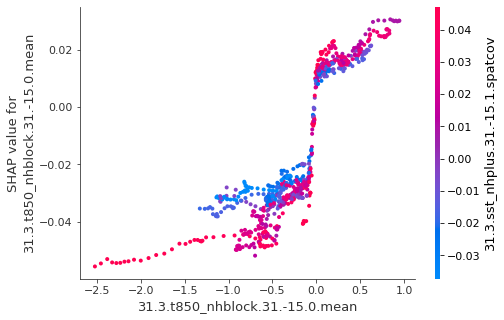

In [16]:
beeswarm = data_for_shapplot(shaps, shaps.df.loc[([31],3),:].dropna(axis = 1, how = 'all'), base_too = False) # single fold
shap.dependence_plot(ind = '31.3.t850_nhblock.31.-15.0.mean',  **beeswarm)

### Map anomalies and correlation patterns
Now lets see the anomalies contributing to a specific moment in fold 3. Reload because we don't want global shap anymore.

In [7]:
shaps.load_data(inputpath = inputpath)

In [8]:
sample = shaps.df.loc[([31],[3],['t850_nhblock'],[31],slice(None),slice(None),slice(None),'mean'),:].iloc[:,[638]]
sample

time                                                             1987-08-26
respagg fold variable     timeagg lag separation clustid metric            
31      3    t850_nhblock 31      -46 -15        0       mean      0.012421
                                                 1       mean     -0.000906

(<Figure size 864x252 with 6 Axes>,
 array([[<GeoAxesSubplot:title={'center':'time = 1987-07-11'}, ylabel="(3, 't850_nhblock', 31, -15)">,
         <GeoAxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'fold = 3, separation = -15, timeagg = 31'}>]],
       dtype=object))

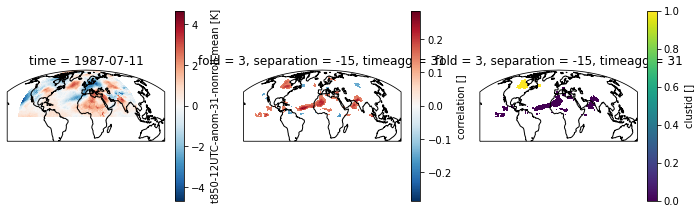

In [9]:
mapresult = mapint.get_anoms(imp=sample, mask_with_clustid=False)
mapplot(mapresult, wrap_per_row=3)

## Visualizing the number of significant cells
To test the effect of the new partial correlation and significance setup in terms of value and number of cells per variable and such

In [24]:
mapint_par = MapInterface(corclustpath=inputpath)
mapint_par.load_one_dataset('z300_nhnorm',31)
mapint_par.load_one_dataset('z300_nhnorm',7)
mapint_par.load_one_dataset('sst_nhplus',7)
#mapint_par.cache_everything()

(<Figure size 1080x252 with 2 Axes>,
 array([[<AxesSubplot:title={'center':'timeagg: 31, fold: None'}, xlabel='separation [days]', ylabel='fraction significant cells'>,
         <AxesSubplot:title={'center':'timeagg: 7, fold: None'}, xlabel='separation [days]'>]],
       dtype=object))

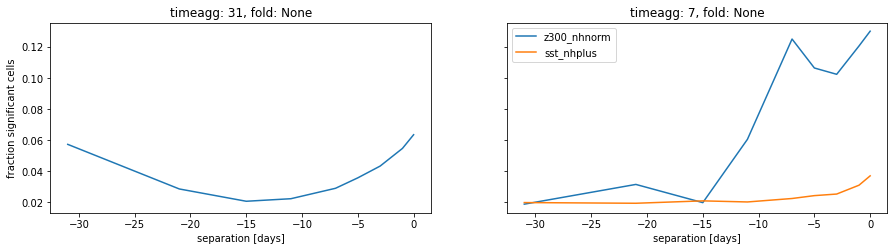

In [26]:
mapint_par.fraction_significant(plot = True, timeaggs = [31,7], fold = None)

## Testing scatterplot of X vs y

In [23]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=31, separation= [-15], quantile = quantile, model=model)
shaps.load_data(inputpath = inputpath, y_too=True)
shaps.global_shap() # Reduces the column axis. Just to determine which is the most important

(<Figure size 360x360 with 1 Axes>,
 array([[<AxesSubplot:title={'center':'validation: 1981-06-01 - 1988-08-31, imp: 0.066'}, xlabel="(3, 'sst_nhplus', 31, -46, -15, 1, 'spatcov')", ylabel='response agg: 31'>]],
       dtype=object))

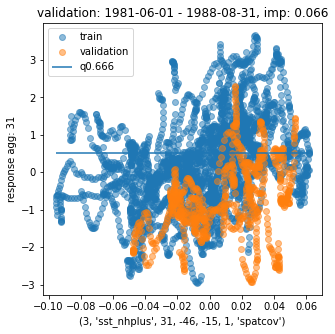

In [33]:
scatterplot(shaps, shaps.df.loc[(31,[3]),:].iloc[[shaps.df.loc[(31,[3]),:].iloc[:,0].argmax()],:], quantile = quantile)

This most important factor is supported by global shap both in training and in validation. It is interesting that with this trended response you see the validation fold have a clear vertical position depending on the timing of the validation fold (now the first, so lowest).

## Y-response plots and contributions for case

In [63]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=[31], separation= [-31,-15], quantile = quantile, model=model)
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

In [35]:
preds = shaps.get_predictions(when = shaps.y.columns, respagg = 31, separation = -15)

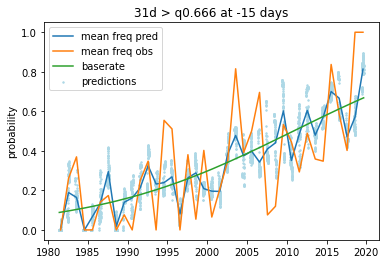

In [60]:
obs = shaps.get_exceedences(when = shaps.y.columns, respagg = 31)
base = shaps.get_baserate(when = shaps.y.columns, respagg = 31)
mean_freq = obs.groupby(obs.index.year).mean()
mean_freq.index = pd.date_range('1981',periods = len(mean_freq), freq = 'A-JUL' )
mean_pred = preds.groupby(preds.index.year).mean()
mean_pred.index = pd.date_range('1981',periods = len(mean_pred), freq = 'A-JUL' )
fig, ax = plt.subplots()
ax.scatter(preds.index, preds.values, s = 2, alpha = 1, label = 'predictions', color = 'lightblue')
ax.set_title('31d > q0.666 at -15 days')
ax.set_ylabel('probability')
ax.plot(mean_pred, label = 'mean freq pred')
ax.plot(mean_freq, label = 'mean freq obs')
ax.plot(base, label = 'baserate')
ax.legend(loc = 'upper left')

Fitting multiple models. And seeing for a case (now summer 2010) how the y response prediction is update from responseagg to responseagg or from separation to separation.

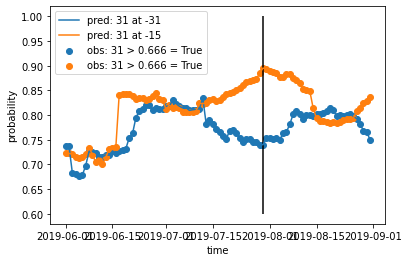

In [67]:
moment = pd.Timestamp('2019-07-30')
fig, ax = yplot(shaps, resp_sep_combinations = [(31,-31),(31,-15)], startdate = '2019-06-01', enddate = '2019-09-01')
ax.vlines(x = moment, ymin= 0.6, ymax = 1, color = 'black')

For a specific slice or even timestamp the contributions of the input to the prediction can be plotted. Because: 'what led to updated prediction, or to the shift?' In the base the probability is not very high, even as late as the last decades. (0.2 on average for the 0.8 quantile)

In [70]:
plotdata = data_for_shapplot(shaps, shaps.df.loc[(31,slice(None),slice(None),slice(None),slice(None),-15),[moment]].dropna(how = 'any'), fit_base = True)
shap.force_plot(**plotdata)

In [72]:
shaps.df

time                                                              1981-06-01  \
respagg fold variable     timeagg lag separation clustid metric                
31      0    siconc_nhmin 7       -38 -31        0       mean            NaN   
                          11      -42 -31        0       mean            NaN   
                          15      -46 -31        0       mean            NaN   
                                                 1       mean            NaN   
                                                 2       mean            NaN   
...                                                                      ...   
        4    z300_nhnorm  11      -26 -15        2       spatcov         NaN   
                          15      -30 -15        0       spatcov         NaN   
                                                 1       spatcov         NaN   
                                                 2       spatcov         NaN   
                                                 3       spatcov         NaN   

time                                                              1981-06-02  \
respagg fold variable     timeagg lag separation clustid metric                
31      0    siconc_nhmin 7       -38 -31        0       mean            NaN   
                          11      -42 -31        0       mean            NaN   
                          15      -46 -31        0       mean            NaN   
                                                 1       mean            NaN   
                                                 2       mean            NaN   
...                                                                      ...   
        4    z300_nhnorm  11      -26 -15        2       spatcov         NaN   
                          15      -30 -15        0       spatcov         NaN   
                                                 1       spatcov         NaN   
                                                 2       spatcov         NaN   
                                                 3       spatcov         NaN   

time                                                              1981-06-03  \
respagg fold variable     timeagg lag separation clustid metric                
31      0    siconc_nhmin 7       -38 -31        0       mean            NaN   
                          11      -42 -31        0       mean            NaN   
                          15      -46 -31        0       mean            NaN   
                                                 1       mean            NaN   
                                                 2       mean            NaN   
...                                                                      ...   
        4    z300_nhnorm  11      -26 -15        2       spatcov         NaN   
                          15      -30 -15        0       spatcov         NaN   
                                                 1       spatcov         NaN   
                                                 2       spatcov         NaN   
                                                 3       spatcov         NaN   

time                                                              1981-06-04  \
respagg fold variable     timeagg lag separation clustid metric                
31      0    siconc_nhmin 7       -38 -31        0       mean            NaN   
                          11      -42 -31        0       mean            NaN   
                          15      -46 -31        0       mean            NaN   
                                                 1       mean            NaN   
                                                 2       mean            NaN   
...                                                                      ...   
        4    z300_nhnorm  11      -26 -15        2       spatcov         NaN   
                          15      -30 -15        0       spatcov         NaN   
                                                 1       spatcov         NaN 

In [71]:
mapint = MapInterface(corclustpath=inputpath, anompath= anompath, impdata=shaps)

(<Figure size 864x252 with 6 Axes>,
 array([[<GeoAxesSubplot:title={'center':'time = 2019-05-29, fold = 4, separation = -31, ...'}, ylabel="(4, 'sst_nhplus', 31, -31)">,
         <GeoAxesSubplot:title={'center':'fold = 4, separation = -31, timeagg = 31'}>,
         <GeoAxesSubplot:title={'center':'fold = 4, separation = -31, timeagg = 31'}>]],
       dtype=object))

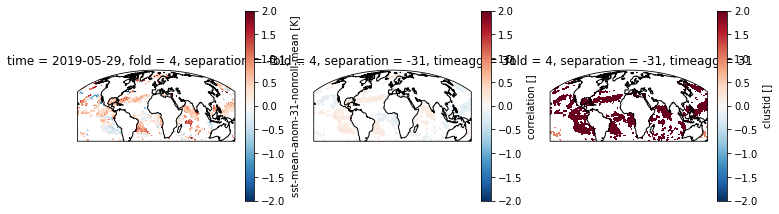

In [90]:
sample = shaps.df.loc[([31],[4],['sst_nhplus'],[31],slice(None),[-31],slice(None),'spatcov'),[moment]]
mapresult = mapint.get_anoms(imp=sample, mask_with_clustid=True)
mapresult.minimums = np.array([-2.0])
mapresult.maximums = np.array([2.0])
mapplot(mapresult, match_scales=True)

In [85]:
mapresult.minimums

In [80]:
sample

respagg  fold  variable    timeagg  lag  separation  clustid  metric 
31       4     sst_nhplus  31       -46  -15         0        spatcov    0.001409
                                                     1        spatcov    0.050476
Name: 2019-07-30 00:00:00, dtype: float64

Look at it from the aggregate perspective (where clustids (and potentially also timeaggs) are lost). Reduces the amount of factors, but does not need to be informative when opposing contributions within the same field are summed.

In [21]:
shaps.reduce_over(what = ['clustid'], axis = 0, how = 'sum')
plotsum = data_for_shapplot(shaps, shaps.df.loc[(31,slice(None),slice(None),slice(None),slice(None),-15),[moment]].dropna(how = 'any'), fit_base = True)
shap.force_plot(**plotsum)

Could not find X matching the selection, indexes might not correspond, proceed without feature values


We can show that adding the regression forest additive shap contributions to the baseline probabilities, is not exactly the same as the full y prediction. This has two reasons:
* shap is not perfectly precise in adding up
* the capping to the range 0-1 is not present

The absence of capping is indeed seen by summing shaps, where values of -0.2 in the beginning would dip the prediction downward.

## Global contributions and interactions
Lets look at the contributions in all data. Beeswarm and dependence plots should be usually made per fold (There is no guarantee that the same clusters per variable/timeagg are involved) Unless one removes the geographic information and averages over the folds.

In [3]:
model = HybridExceedenceModel(fit_base_to_all_cv = True, base_only = False, n_jobs = 15, max_depth = 5, min_samples_split = 30, n_estimators = 2500, max_features = 35)
shaps = ImportanceData(shappath, respagg=[31], separation= [-15], quantile = quantile, model=model)
shaps.load_data(X_too = True, y_too = True, inputpath = inputpath)

First for a fold (fold 3). It is basically the same as the barplot above, but then not collapsed in a single number. Common is that the most important in terms of avgabsshap are on top

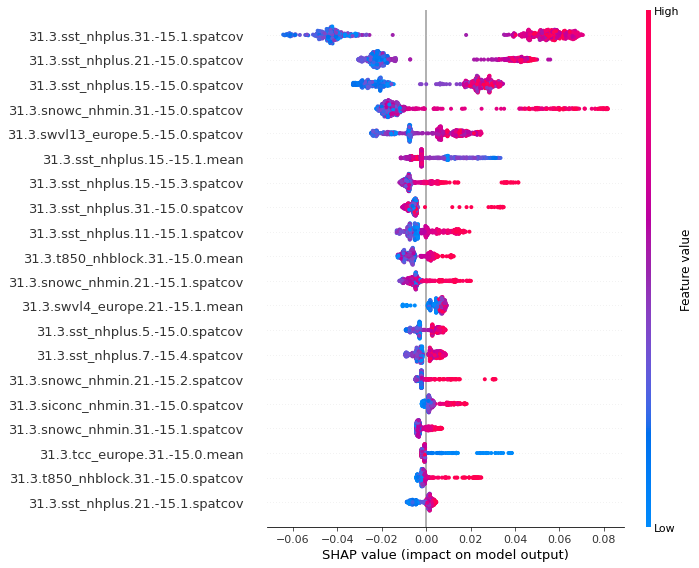

In [4]:
beeswarm = data_for_shapplot(shaps, shaps.df.loc[([31],3),:].dropna(axis = 1, how = 'all'), base_too = False) # single fold
shap.summary_plot(**beeswarm)

Now the (informal) interaction. Which is supposed to select the most interacting other variable

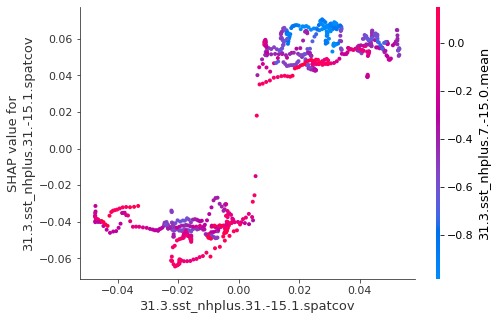

In [45]:
shap.dependence_plot(ind = '31.3.sst_nhplus.31.-15.1.spatcov',  **beeswarm)

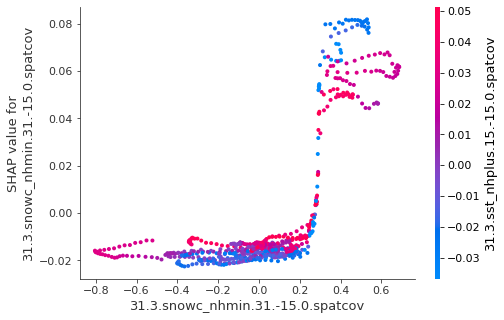

In [46]:
shap.dependence_plot(ind = '31.3.snowc_nhmin.31.-15.0.spatcov',  **beeswarm)

Actually the version on all validation folds is impossible. There are no X.values.